In [67]:
import warnings
import numpy as np
import os
import pandas as pd
import itertools
import json
from pathlib import Path
from jiwer import cer
import torch
import torchaudio
from tqdm import tqdm
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, GPT2Tokenizer, GPT2Model
from sklearn.metrics.pairwise import cosine_similarity
import random 

warnings.filterwarnings("ignore")

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained tokenizer and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-960h').to(device)

# GPT2
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2Model.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
num_of_samples = 10000
batch_size = 4
random_seed = 53

In [70]:
audio_paths = []
actual_transcripts = []

# Base directories
text_base_dir = Path("C:\\Users\\a_has\\Desktop\\DS_10283_3443\\txt")
audio_base_dir = Path("C:\\Users\\a_has\\Desktop\\DS_10283_3443\\wav48_silence_trimmed")

# Collect all text files across all subfolders
all_text_files = []
for subfolder in text_base_dir.iterdir():
    if subfolder.is_dir():
        text_files = list(subfolder.glob("*.txt"))
        for text_file in text_files:
            all_text_files.append((subfolder.name, text_file))

random.seed(random_seed)
selected_files = random.sample(all_text_files, min(num_of_samples, len(all_text_files)))

# Process the selected files
for speaker_id, text_file in selected_files:
    with open(text_file, "r", encoding="utf-8") as f:
        content = f.read().strip().lower().replace(",", "").replace(".", "").replace("?", "")

    # Construct the corresponding audio file path
    audio_filename = text_file.stem + "_mic1.flac"
    audio_file = audio_base_dir / speaker_id / audio_filename

    # Append to lists if the audio file exists
    if audio_file.exists():
        audio_paths.append(audio_file.resolve())
        actual_transcripts.append(content)
    else:
        print(f"Missing audio file for: {text_file}")

Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_350.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_184.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_068.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_007.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_381.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_355.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_036.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_311.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_085.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_124.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_066.txt
Missing audio file for: C:\Users\a_has\Desktop\DS_10283_3443\txt\p362\p362_078.txt
Miss

In [71]:
results = []

for i in tqdm(range(0, len(audio_paths), batch_size)):
    batch_files = audio_paths[i : i + batch_size]
    batch_actual_transcripts = actual_transcripts[i : i + batch_size]
    
    waveforms = []
    max_length = 0  # Track max waveform length

    # Load and resample audio files
    for audio_file in batch_files:
        waveform, sample_rate = torchaudio.load(audio_file)
        if sample_rate != 16000:
            transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = transform(waveform)

        waveform = waveform.squeeze(0)  # Remove extra dimension
        waveforms.append(waveform)
        max_length = max(max_length, waveform.shape[0])  # Find max length in batch

    # Pad all waveforms to max_length
    padded_waveforms = []
    for waveform in waveforms:
        pad_length = max_length - waveform.shape[0]
        padded_waveform = torch.nn.functional.pad(waveform, (4000, pad_length)) # right_pad + fix left_pad
        padded_waveforms.append(padded_waveform)

    # Convert list of tensors to a batch tensor
    batch_waveforms = torch.stack(padded_waveforms)

    # Convert list of waveforms to a batch tensor with padding
    input_values = processor(batch_waveforms.numpy(), return_tensors="pt", padding=True, sampling_rate=16000)["input_values"]

    # Step 3: Perform model inference in batch
    with torch.no_grad():
        logits = model(input_values).logits

    # Step 4: Decode predictions in batch
    predicted_ids = torch.argmax(logits, dim=-1)
    transcriptions = processor.batch_decode(predicted_ids)

    # Step 5: Compute similarity metrics
    for j, transcription in enumerate(transcriptions):
        gen_text = transcription.strip().lower()
        actual_text = batch_actual_transcripts[j]

        def get_gpt2_embedding(text):
            if not text.strip():  # Check if the text is empty
                return torch.zeros(1, 768)  # Return a zero vector with GPT-2 embedding size (768)
            inputs = gpt2_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
            with torch.no_grad():
                outputs = gpt2_model(**inputs)
            return outputs.last_hidden_state.mean(dim=1)  # Get mean-pooled embedding
        
        actual_embedding = get_gpt2_embedding(actual_text)
        gen_embedding = get_gpt2_embedding(gen_text)

        cosine_sim = cosine_similarity(actual_embedding.numpy(), gen_embedding.numpy())[0][0]
        cer_score = cer(actual_text, gen_text)

        results.append({
            "audio_file": batch_files[j],
            "actual_transcript": actual_text,
            "generated_transcript": gen_text,
            "CER": cer_score,
            "GPT-2 Cosine Similarity": cosine_sim
        })

100%|██████████| 2480/2480 [1:48:11<00:00,  2.62s/it]  


               CER  GPT-2 Cosine Similarity
count  9920.000000              9920.000000
mean      0.031778                 0.999342
std       0.060390                 0.001887
min       0.000000                 0.967512
25%       0.000000                 0.999562
50%       0.000000                 1.000000
75%       0.043478                 1.000000
max       0.769231                 1.000001


array([[<Axes: title={'center': 'CER'}>,
        <Axes: title={'center': 'GPT-2 Cosine Similarity'}>]],
      dtype=object)

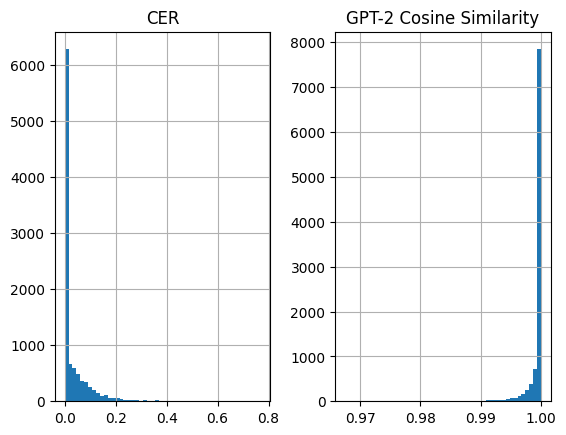

In [94]:
df_results = pd.DataFrame(results)
df_results.to_csv("Audio_Token_Test.csv")
pd.set_option("display.max_colwidth", None)
print(df_results.describe())
df_results.hist(bins=50)

In [76]:
print("Best cases:")
display(df_results.sort_values("GPT-2 Cosine Similarity", ascending=False).head(10))

Best cases:


,audio_file,actual_transcript,generated_transcript,CER,GPT-2 Cosine Similarity
832,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p239\p239_248_mic1.flac,adams is surely worth a chance,adams is surely worth a chance,0.0,1.000001
5149,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p227\p227_157_mic1.flac,adams is surely worth a chance,adams is surely worth a chance,0.0,1.000001
2198,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p343\p343_083_mic1.flac,that was the easy election,that was the easy election,0.0,1.000001
5463,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p258\p258_064_mic1.flac,that was the easy election,that was the easy election,0.0,1.000001
1918,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p271\p271_164_mic1.flac,it is perfectly evident that the time for an inquiry will come,it is perfectly evident that the time for an inquiry will come,0.0,1.000001
6891,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p269\p269_231_mic1.flac,it is perfectly evident that the time for an inquiry will come,it is perfectly evident that the time for an inquiry will come,0.0,1.000001
7189,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p261\p261_229_mic1.flac,life is too short to be bitter,life is too short to be bitter,0.0,1.000001
9559,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p229\p229_067_mic1.flac,that was the easy election,that was the easy election,0.0,1.000001
5764,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p299\p299_180_mic1.flac,it's not in my nature,it's not in my nature,0.0,1.000001
1368,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p347\p347_420_mic1.flac,i just want to get rid of it,i just want to get rid of it,0.0,1.000001


In [78]:
print("Worst cases:")
display(df_results.sort_values("GPT-2 Cosine Similarity").head(10))
display(df_results.sort_values("CER", ascending=False).head(10))

Worst cases:


,audio_file,actual_transcript,generated_transcript,CER,GPT-2 Cosine Similarity
6952,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p265\p265_338_mic1.flac,that would help,thotrid help,0.400000,0.967512
3817,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p255\p255_032_mic1.flac,then suddenly they weren't,then suddenly beware t,0.269231,0.970162
547,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p278\p278_310_mic1.flac,i couldn't really work outside edinburgh,i culdn't really work outside enbragh,0.125000,0.973024
4232,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p351\p351_104_mic1.flac,i didn't deserve to be sent off,and in deserve to be sent off,0.193548,0.974513
6656,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p285\p285_300_mic1.flac,it could work,acidwag,0.769231,0.976366
2941,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p340\p340_289_mic1.flac,it wasn't an easy decision,it was an an easy decision,0.115385,0.976821
9707,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p313\p313_295_mic1.flac,we gave them the goal,we gevim the gor,0.380952,0.977576
5082,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p254\p254_091_mic1.flac,it may well have been,it my relobing,0.571429,0.977897
1646,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p247\p247_123_mic1.flac,it isn't a happy memory,isn't a happy memory,0.130435,0.978251
3968,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p264\p264_150_mic1.flac,did he trip,te titrip,0.545455,0.978781


,audio_file,actual_transcript,generated_transcript,CER,GPT-2 Cosine Similarity
6656,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p285\p285_300_mic1.flac,it could work,acidwag,0.769231,0.976366
5261,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p323\p323_171_mic1.flac,i'm just feeling very tired - but it's great,hid but its great,0.636364,0.997916
5082,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p254\p254_091_mic1.flac,it may well have been,it my relobing,0.571429,0.977897
3968,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p264\p264_150_mic1.flac,did he trip,te titrip,0.545455,0.978781
9437,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p263\p263_253_mic1.flac,did he trip,de di chip,0.545455,0.981346
6782,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p239\p239_221_mic1.flac,i was caught out a little bit,i've scaught houseless a bit,0.517241,0.996126
686,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p351\p351_407_mic1.flac,but the foreign secretary can cope,but to fine sycer shaking cope,0.500000,0.995412
8101,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p326\p326_127_mic1.flac,i've beaten her a few times,i've base in our fettarms,0.481481,0.994594
2424,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p265\p265_032_mic1.flac,it has failed,it dues field,0.461538,0.992286
4963,C:\Users\a_has\Desktop\DS_10283_3443\wav48_silence_trimmed\p345\p345_245_mic1.flac,this is wonderful news,this is one of freneuse,0.454545,0.996692


In [80]:
# Character Error Rate (CER): Measures character-level errors
mean_values = df_results[["CER", "GPT-2 Cosine Similarity"]].mean()
display(mean_values)

CER                        0.031778
GPT-2 Cosine Similarity    0.999342
dtype: float64